# First Test 

## Each Test is divided by their level . Each level contain their job title test 

## In this test we are going to train feed forward neural network with two hidden layer with each job title data 

### first job title is web development of level 0

First we make data preprocessing templete of level 0 
which will be used by all job title test

their are following steps for data processing
    1. find all vocablory in files
    2. divide all vocablory in two parts
        a. known vocab => which have word2vec in word embeddided file
        b. unknown vocab => which does not have word2vec 
    3. find all known vvocab vector and generate all unknown voacb vector and save in cpickle file
    4. take each sentence from training file and make sentence vector using word2vec file and save it 

In [1]:
import io
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import os
import numpy as np
import cPickle as pic
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'      # this is used when you want to run on cpu not gpu

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

In [2]:
def get_vocab(file_name):
    lexicon = []
    with io.open(file_name, 'r', encoding='cp437') as f:
        contents = f.readlines()
        for l in contents:
            all_words = tokenizer.tokenize(l)
            #all_words = word_tokenize(l)
            lexicon += list(all_words)
    lexicon = [(lemmatizer.lemmatize(i)).encode('utf8').lower() for i in lexicon]
    lexicon = sorted(set(lexicon))

    return lexicon

def get_unknown_vocab(fname, words):
    f2 = io.open(fname, 'rb').read()
    vocab = f2.splitlines()
    known_vocab = []
    unknown_vocab = []
    for word in words:
        if word in vocab:
            known_vocab.append(word)
        else:
            unknown_vocab.append(word)
    return known_vocab, unknown_vocab

def get_wiki_glove_vector(fname, words):
    vectors = {}
    W = []
    vocab = {}
    ivocab = {}
    f1 = open(fname, 'rb').read()
    for line in f1.splitlines():
        temp = line.split()
        vectors[temp[0]] = map(float, temp[1:])

    vocab_size = len(words)

    for i in range(len(words)):
        W.append(vectors[words[i]])
        vocab[words[i]] = i
        ivocab[i] = words[i]
    W = np.array(W)
    # normalize each word vector to unit variance
    #print W[0:2], W[-1:-3]
    W_norm = np.zeros(W.shape)
    d = (np.sum(W ** 2, 1) ** (0.5))
    W_norm = (W.T / d).T

    return W_norm, vocab, ivocab


def get_unknown_vec(words, word2vec, vocab, ivocab):
    old_size = len(vocab)
    word2vec = list(word2vec)
    for i in range(len(words)):
        word2vec.append(np.random.uniform(-0.25, 0.25, len(word2vec[0])))
        vocab[words[i]] = i+old_size
        ivocab[i+old_size] = words[i]
    return word2vec, vocab, ivocab

In [3]:
glove_file = '/home/sumit/stanford-nlp/glove/wiki_GVector/glove.6B.100d.txt'
glove_vocab_file = '/home/sumit/stanford-nlp/glove/wiki_GVector/vocab.txt'
word2vec_file = "/home/sumit/PycharmProjects/ResumeParser/Data/resume_segments/Test/web_word2vec.p"
dirlist_path = '/home/sumit/PycharmProjects/ResumeParser/Data/resume_segments/Level0/'
dirlist = os.walk(dirlist_path).next()[2] # only give files not folders
#dirlist = os.listdir(dirlist_path)

if not os.path.isfile(word2vec_file):
    # get vocablory of all file
    vocab = []

    for files in dirlist:
        vocab += get_vocab(dirlist_path+files)
    vocab = sorted(set(vocab))
    print("vocab length: ", len(vocab))
    # get the glove vector
    known_vocab, unknown_vocab = get_unknown_vocab(glove_vocab_file, vocab)
    print("known_vocab length: ", len(known_vocab))
    print("unknown_vocab length: ", len(unknown_vocab))
    Word2vec, vocab, ivocab = get_wiki_glove_vector(glove_file, known_vocab)
    Word2vec, vocab, ivocab = get_unknown_vec(unknown_vocab,Word2vec, vocab, ivocab)
    pic.dump([Word2vec, vocab, ivocab ], open(word2vec_file, 'wb'))
    print("word2vec created")

('vocab length: ', 10793)
('known_vocab length: ', 8567)
('unknown_vocab length: ', 2226)
word2vec created


In [4]:
def get_avg_sen2vec(fname, word2vec_fname, output):
    sen2vec = []
    with open(word2vec_fname, 'rb') as f:
        word2vec, vocab, ivocab = pic.load(f)

    with io.open(fname, 'r', encoding='cp437') as f:
        contents = f.readlines()
        for l in contents:
            temp = np.zeros(len(word2vec[0]), dtype=float)
            all_words = tokenizer.tokenize(l)
            lexicon = list(all_words)
            lexicon = [(lemmatizer.lemmatize(i)).encode('utf8').lower() for i in lexicon]
            for word in lexicon:
                temp += word2vec[vocab[word]]
            sen2vec.append([temp, output])
    return sen2vec

def get_2D_sen2vec(fname, word2vec_fname, output, m):
    sen2vec = []
    with open(word2vec_fname, 'rb') as f:
        word2vec, vocab, ivocab = pic.load(f)

    with io.open(fname, 'r', encoding='cp437') as f:
        contents = f.readlines()
        for l in contents:
            temp = np.zeros([m, len(word2vec[0])], dtype=float)
            count = 0
            all_words = tokenizer.tokenize(l)
            lexicon = list(all_words)
            lexicon = [(lemmatizer.lemmatize(i)).encode('utf8').lower() for i in lexicon]
            for word in lexicon:
                temp[count] = word2vec[vocab[word]]
                count += 1
            sen2vec.append([temp, output])
    return sen2vec

sen2vec_file = "/home/sumit/PycharmProjects/ResumeParser/Data/resume_segments/Test/web_sen2vec.p"


if not os.path.isfile(sen2vec_file):
    # get sentence vector from file
    sen2vec = []
    count  = 0

    for files in dirlist:
        output = [0 for i in range(9)]
        output[count] = 1
        sen2vec +=  get_avg_sen2vec(dirlist_path+files, word2vec_file, output)
        count += 1
    import random
    random.shuffle(sen2vec)
    pic.dump(sen2vec, open(sen2vec_file, 'wb'))
    print("sen2vec created")

sen2vec created


In [5]:
f = io.open(sen2vec_file, 'rb')
sen2vec = pic.load(f)
f.close()
print(len(sen2vec))

train_data = np.array(sen2vec[0:int(len(sen2vec)*0.8)])
test_data = np.array(sen2vec[int(len(sen2vec)*0.8):])
train_x = np.array(list(train_data[:, 0]))
train_y = np.array(list(train_data[:, 1]))
test_x = np.array(list(test_data[:, 0]))
test_y = np.array(list(test_data[:, 1]))
print("train data length: ", len(train_data))
print("test data length: ", len(test_data))
print("structure of train_x", train_x[0])
print("structure of train_y", train_y[0])

26037
('train data length: ', 20829)
('test data length: ', 5208)
('structure of train_x', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))
('structure of train_y', array([0, 0, 0, 0, 0, 1, 0, 0, 0]))


In [6]:
from keras.models import Sequential
from keras.layers import Dense

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 1024, kernel_initializer = 'uniform', activation = 'relu', input_dim = 100))

# Adding the second hidden layer
classifier.add(Dense(units = 512, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(train_x, train_y, batch_size = 30, epochs = 20)

Using TensorFlow backend.


Epoch 1/20
20829/20829 [==============================] - 27s - loss: 0.8930 - acc: 0.7232    
Epoch 2/20
20829/20829 [==============================] - 10s - loss: 0.7407 - acc: 0.7691    
Epoch 3/20
20829/20829 [==============================] - 10s - loss: 0.6871 - acc: 0.7853    
Epoch 4/20
20829/20829 [==============================] - 11s - loss: 0.6433 - acc: 0.7965    
Epoch 5/20
20829/20829 [==============================] - 10s - loss: 0.6053 - acc: 0.8074    
Epoch 6/20
20829/20829 [==============================] - 10s - loss: 0.5716 - acc: 0.8178    
Epoch 7/20
20829/20829 [==============================] - 10s - loss: 0.5388 - acc: 0.8265    
Epoch 8/20
20829/20829 [==============================] - 11s - loss: 0.5146 - acc: 0.8347    
Epoch 9/20
20829/20829 [==============================] - 11s - loss: 0.4864 - acc: 0.8434    
Epoch 10/20
20829/20829 [==============================] - 10s - loss: 0.4661 - acc: 0.8480    
Epoch 11/20
20829/20829 [========================

In [7]:
print dirlist
y_pred = classifier.predict(test_x)


correct = np.equal(np.argmax(y_pred, 1), np.argmax(test_y, 1))
accuracy = np.mean(correct)
print("Accuracy", accuracy)
print "pred: ", np.argmax(y_pred, 1)[0:30]
print "real: ", np.argmax(test_y, 1)[0:30]
print "pred: ", np.argmax(y_pred, 1)[30:65]
print "real: ", np.argmax(test_y, 1)[30:65]
print "pred: ", np.argmax(y_pred, 1)[65:100]
print "real: ", np.argmax(test_y, 1)[65:100]

['projects.txt', 'education.txt', 'extra.txt', 'basic_info.txt', 'mimc.txt', 'experience.txt', 'skills.txt', 'summary.txt', 'certificates.txt']
('Accuracy', 0.78283410138248843)
pred:  [5 6 5 5 5 5 1 5 7 5 5 5 3 5 5 5 6 3 5 5 1 5 5 5 5 1 7 5 5 7]
real:  [5 6 5 6 5 5 1 1 3 5 5 5 3 5 7 3 6 3 5 5 1 5 5 5 5 1 7 5 3 7]
pred:  [3 5 5 7 5 5 5 5 6 5 5 5 5 5 5 5 5 6 6 5 5 5 1 6 5 5 1 6 5 5 5 8 5 5 3]
real:  [3 6 2 7 5 7 5 5 6 5 5 5 5 5 8 5 6 6 6 1 0 5 1 6 5 5 1 6 3 5 5 8 6 5 3]
pred:  [5 5 5 5 5 3 6 5 5 5 6 5 5 1 5 5 5 5 5 5 7 6 5 5 5 1 7 5 5 6 6 5 5 1 5]
real:  [6 5 5 5 5 3 6 1 5 5 6 5 3 1 3 5 8 5 5 6 7 6 5 5 5 1 7 5 5 6 6 5 5 1 5]


In [8]:
sen2vec_file = "/home/sumit/PycharmProjects/ResumeParser/Data/resume_segments/Test/web_sen2vec2D.p"


if not os.path.isfile(sen2vec_file):
    # get sentence vector from file
    sen2vec = []
    count  = 0
    for files in dirlist:
        output = [0 for i in range(9)]
        output[count] = 1
        sen2vec +=  get_2D_sen2vec(dirlist_path+files, word2vec_file, output, 50)
        count += 1
    import random
    random.shuffle(sen2vec)
    pic.dump(sen2vec, open(sen2vec_file, 'wb'))
    print("sen2vec created")

sen2vec created


In [9]:
f = io.open(sen2vec_file, 'rb')
sen2vec = pic.load(f)
f.close()
print(len(sen2vec))

train_data = np.array(sen2vec[0:int(len(sen2vec)*0.8)])
test_data = np.array(sen2vec[int(len(sen2vec)*0.8):])
train_x = np.array(list(train_data[:, 0]))
train_y = np.array(list(train_data[:, 1]))
test_x = np.array(list(test_data[:, 0]))
test_y = np.array(list(test_data[:, 1]))
print("train data length: ", len(train_data))
print("test data length: ", len(test_data))
print("structure of train_x", train_x[0])
print("structure of train_y", train_y[0])
train_x = np.reshape(train_x, [-1, 50, 100, 1])
test_x = np.reshape(test_x, [-1, 50, 100, 1])
print(train_x.shape, test_x.shape)

26037
('train data length: ', 20829)
('test data length: ', 5208)
('structure of train_x', array([[ 0.04151403, -0.01772548, -0.03327429, ..., -0.07331215,
         0.10822663,  0.16146472],
       [-0.00656124, -0.04206555,  0.12508174, ..., -0.02506376,
         0.14220549,  0.04648907],
       [-0.02246484, -0.01360233, -0.00747819, ..., -0.01930532,
         0.15860482,  0.02588506],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]]))
('structure of train_y', array([0, 0, 0, 0, 0, 1, 0, 0, 0]))
((20829, 50, 100, 1), (5208, 50, 100, 1))


In [10]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense

# Initialising the CNN
cnn_classifier = Sequential()

# Step 1 - Convolution
cnn_classifier.add(Conv2D(50, (4, 100), input_shape = (50, 100, 1), activation = 'relu'))

# Step 2 - Pooling
cnn_classifier.add(AveragePooling2D(pool_size = (2, 1)))

# Step 3 - Flattening
cnn_classifier.add(Flatten())

# Step 4 - Full connection
cnn_classifier.add(Dense(units = 1024, activation = 'relu'))
cnn_classifier.add(Dense(units = 512, activation = 'relu'))
cnn_classifier.add(Dense(units = 9, activation = 'softmax'))

# Compiling the CNN
cnn_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
cnn_classifier.fit(train_x, train_y, batch_size = 30, epochs = 20)

Epoch 1/20
20829/20829 [==============================] - 28s - loss: 0.9146 - acc: 0.7145    
Epoch 2/20
20829/20829 [==============================] - 24s - loss: 0.7081 - acc: 0.7817    
Epoch 3/20
20829/20829 [==============================] - 22s - loss: 0.6396 - acc: 0.8022    
Epoch 4/20
20829/20829 [==============================] - 23s - loss: 0.5792 - acc: 0.8204    
Epoch 5/20
20829/20829 [==============================] - 22s - loss: 0.5267 - acc: 0.8336    
Epoch 6/20
20829/20829 [==============================] - 22s - loss: 0.4755 - acc: 0.8480    - ETA: 
Epoch 7/20
20829/20829 [==============================] - 23s - loss: 0.4403 - acc: 0.8592    
Epoch 8/20
20829/20829 [==============================] - 22s - loss: 0.4096 - acc: 0.8677    
Epoch 9/20
20829/20829 [==============================] - 22s - loss: 0.3862 - acc: 0.8760    
Epoch 10/20
20829/20829 [==============================] - 24s - loss: 0.3753 - acc: 0.8798    
Epoch 11/20
20829/20829 [=================

In [11]:
print dirlist
y_pred = cnn_classifier.predict(test_x)


correct = np.equal(np.argmax(y_pred, 1), np.argmax(test_y, 1))
accuracy = np.mean(correct)
print("Accuracy", accuracy)
print "pred: ", np.argmax(y_pred, 1)[0:30]
print "real: ", np.argmax(test_y, 1)[0:30]
print "pred: ", np.argmax(y_pred, 1)[30:65]
print "real: ", np.argmax(test_y, 1)[30:65]
print "pred: ", np.argmax(y_pred, 1)[65:100]
print "real: ", np.argmax(test_y, 1)[65:100]

['projects.txt', 'education.txt', 'extra.txt', 'basic_info.txt', 'mimc.txt', 'experience.txt', 'skills.txt', 'summary.txt', 'certificates.txt']
('Accuracy', 0.77803379416282648)
pred:  [0 2 3 5 5 7 5 5 5 5 5 5 5 5 5 5 6 1 5 5 5 5 5 5 5 1 5 5 5 5]
real:  [0 8 3 5 5 7 5 5 5 5 5 2 5 5 5 5 6 1 5 5 5 5 5 3 5 1 1 5 5 5]
pred:  [5 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 5]
real:  [7 5 5 5 5 7 6 5 5 5 5 7 5 5 5 5 5 5 5 5 6 5 5 6 5 5 5 5 5 7 5 5 6 5 6]
pred:  [5 5 5 5 5 5 6 1 5 5 5 5 5 6 5 5 5 5 5 5 6 5 5 5 5 5 5 5 6 7 3 5 5 5 5]
real:  [5 5 6 5 5 5 6 1 5 3 5 5 5 6 5 5 5 5 5 0 8 5 5 5 0 6 5 5 6 7 3 5 6 5 3]


Now we take any resume and predict the output 

In [45]:
resume_file = "/home/sumit/PycharmProjects/ResumeParser/Data/resume_segments/Test/sample.txt"
# get vocablory of all file
vocab = get_vocab(resume_file)
print("vocab length: ", len(vocab))
# get the glove vector
known_vocab, unknown_vocab = get_unknown_vocab(glove_vocab_file, vocab)
print("known_vocab length: ", len(known_vocab))
print("unknown_vocab length: ", len(unknown_vocab))
Word2vec, vocab, ivocab = get_wiki_glove_vector(glove_file, known_vocab)
Word2vec, vocab, ivocab = get_unknown_vec(unknown_vocab,Word2vec, vocab, ivocab)

('vocab length: ', 144)
('known_vocab length: ', 141)
('unknown_vocab length: ', 3)


In [13]:
def get_avg_Testsen2vec(fname, word2vec, vocab, ivocab):
    sen2vec = []

    with io.open(fname, 'r', encoding='cp437') as f:
        contents = f.readlines()
        for l in contents:
            temp = np.zeros(len(word2vec[0]), dtype=float)
            all_words = tokenizer.tokenize(l)
            lexicon = list(all_words)
            lexicon = [(lemmatizer.lemmatize(i)).encode('utf8').lower() for i in lexicon]
            for word in lexicon:
                temp += word2vec[vocab[word]]
            sen2vec.append(temp)
    return sen2vec

def get_2D_Testsen2vec(fname,  word2vec, vocab, ivocab , m):
    sen2vec = []

    with io.open(fname, 'r', encoding='cp437') as f:
        contents = f.readlines()
        for l in contents:
            temp = np.zeros([m, len(word2vec[0])], dtype=float)
            count = 0
            all_words = tokenizer.tokenize(l)
            lexicon = list(all_words)
            lexicon = [(lemmatizer.lemmatize(i)).encode('utf8').lower() for i in lexicon]
            for word in lexicon:
                temp[count] = word2vec[vocab[word]]
                count += 1
            sen2vec.append(temp)
    return sen2vec

In [1]:
sen2vec = get_avg_Testsen2vec(resume_file, Word2vec, vocab, ivocab)
print dirlist

y_pred = classifier.predict(np.array(sen2vec))
with open(resume_file, 'r') as f:
    content = f.readlines()
count = 0
for line in content:
    print line ,'=>', dirlist[np.argmax(y_pred, 1)[count]][:-4]
    count += 1

NameError: name 'get_avg_Testsen2vec' is not defined

accuracy = 85%

In [15]:
sen2vec = get_2D_Testsen2vec(resume_file, Word2vec, vocab, ivocab, 50)
print dirlist
sen2vec = np.reshape(np.array(sen2vec), (len(sen2vec), 50, 100, 1))
y_pred = cnn_classifier.predict(np.array(sen2vec))
with open(resume_file, 'r') as f:
    content = f.readlines()
count = 0
for line in content:
    print line ,'=>', dirlist[np.argmax(y_pred, 1)[count]][:-4]
    count += 1

['projects.txt', 'education.txt', 'extra.txt', 'basic_info.txt', 'mimc.txt', 'experience.txt', 'skills.txt', 'summary.txt', 'certificates.txt']
Andrew Ang
=> basic_info
Data Engineer at Harvard
=> experience
Summary
=> experience
Data analyst and engineer, experienced in applying data science to a variety of domains. I currently develop the
=> experience
 research & analytics data infrastructure for Harvard's edX and Canvas courses.
=> skills
I received my B.S.E. in Biomedical Engineering from Duke University, after attending Phillips Academy
=> experience
 Andover. My current interests include data engineering and visualization technologies, Bayesian machine
=> experience
 learning, and online education.
=> experience
Experience
=> experience
Data Engineer  at   Harvard University
=> experience
2016  -  Present (less than a year)
=> skills
VPAL Research Group, Office of the Vice Provost for Advances in Learning
=> experience
Developing the research & analytics data infrastructure for 

[[-0.18364073 -0.59778756 -0.32114431  5.13225603 -0.16906515 -1.64212716
  -0.37758484 -0.23207988 -0.34146228  1.        ]
 [-0.18364017 -0.59928918 -0.3211439  -0.26858801 -0.16906515  0.83884495
  -0.37758505 -0.23207988 -0.34146228  2.        ]
 [-0.05478407 -0.59905958 -0.27409041  2.65678644 -0.16897485 -0.56382787
  -0.20594506 -0.0495648  -0.32125312  3.        ]
 [-0.17301761 -0.59881675  0.08201764 -0.13216363 -0.16905777 -0.16590154
  -0.36059827  5.65341616 -0.34131786  4.        ]
 [-0.18188469 -0.59915411 -0.32094139 -0.2685602  -0.16906515  0.83822489
  -0.37460428 -0.23207973 -0.34144646  5.        ]]


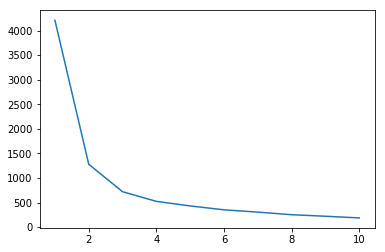

[-0.18364073  1.        ]


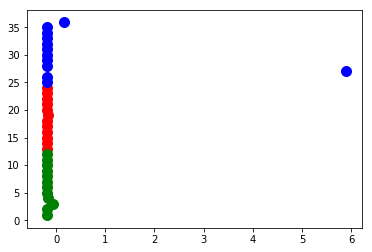

[2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
[-0.59778756  1.        ]


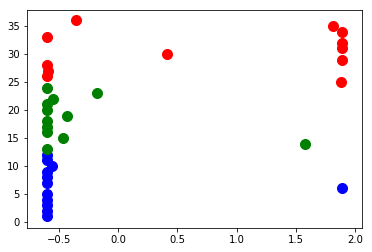

[1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
[-0.32114431  1.        ]


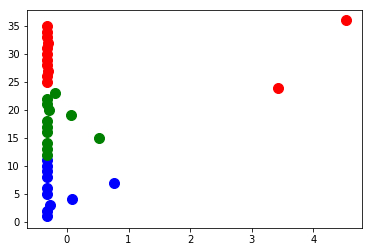

[1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 5.13225603  1.        ]


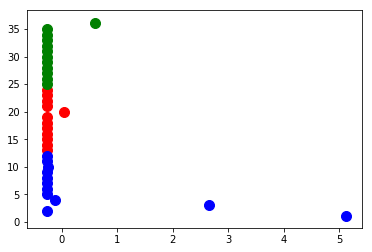

[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2]
[-0.16906515  1.        ]


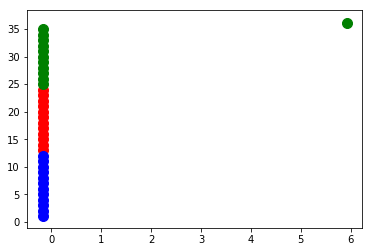

[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2]
[-1.64212716  1.        ]


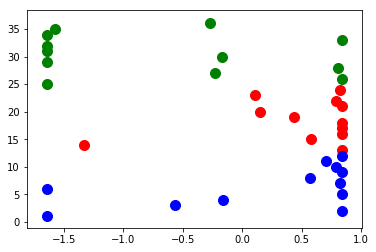

[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2]
[-0.37758484  1.        ]


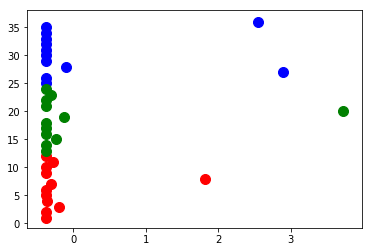

[0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1]
[-0.23207988  1.        ]


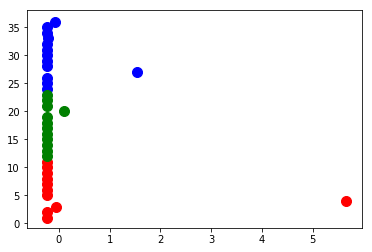

[0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1]
[-0.34146228  1.        ]


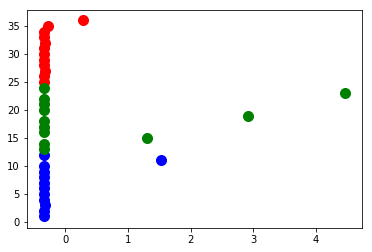

[1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]


In [67]:
sen2vec = get_avg_Testsen2vec(resume_file, Word2vec, vocab, ivocab)
pred = classifier.predict(np.array(sen2vec))
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
pred = sc_x.fit_transform(pred)
index = np.array([[i] for i in range(1, len(sen2vec)+1)])
pred = np.append(pred, index, axis=1)

print pred[0:5]
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    cluster = KMeans(n_clusters=i)
    cluster.fit(pred)
    wcss.append(cluster.inertia_)

plt.plot(range(1, 11), wcss)
plt.show()
for j in range(9):
    cluster = KMeans(n_clusters=3)
    y_pred = cluster.fit_predict(pred[:, [j, 9]])
    print pred[0, [j, 9]]
    color = ['red', 'blue', 'green', 'pink', 'black']

    for i in range(5):
        plt.scatter(pred[y_pred==i, j], pred[y_pred==i, 9], color=color[i], s=100)
    #plt.scatter(cluster.cluster_centers_[:,0], cluster.cluster_centers_[:,1], s=300, color='yellow')
    plt.show()
    print y_pred

[[  4.74430738e-12   6.04256173e-04   2.80522255e-11   9.99395609e-01
    4.97343708e-18   1.63708364e-07   8.58475158e-09   3.81035318e-13
    3.41450063e-11   1.00000000e+00]
 [  1.42571022e-08   7.15242621e-08   8.29193658e-10   1.24227918e-05
    8.47126894e-21   9.99987483e-01   4.37355402e-10   2.59606208e-11
    6.44551981e-11   2.00000000e+00]
 [  3.31133557e-03   9.24433189e-05   9.22815889e-05   5.41329682e-01
    1.04221671e-08   4.34622377e-01   8.32530018e-03   1.17113097e-02
    5.15208289e-04   3.00000000e+00]
 [  2.72991048e-04   1.90144943e-04   7.90676801e-04   2.52566710e-02
    8.50912396e-10   5.95011652e-01   8.23933166e-04   3.77650231e-01
    3.68193105e-06   4.00000000e+00]
 [  4.51262058e-05   5.43985516e-05   3.97957876e-07   1.75739970e-05
    1.30268553e-15   9.99737561e-01   1.44580787e-04   1.02604876e-08
    4.03422234e-07   5.00000000e+00]]


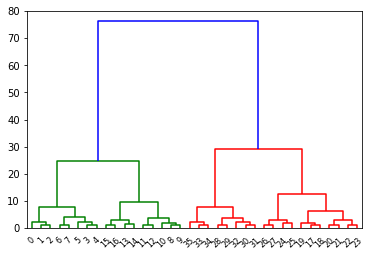

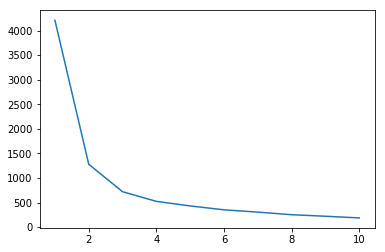

[  4.74430738e-12   1.00000000e+00]


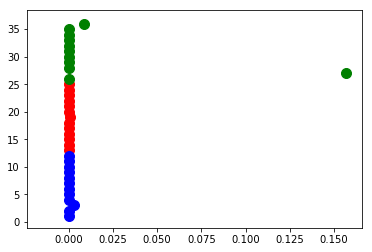

[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2]
[  6.04256173e-04   1.00000000e+00]


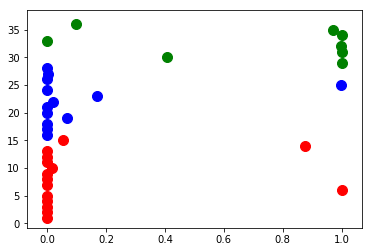

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
[  2.80522255e-11   1.00000000e+00]


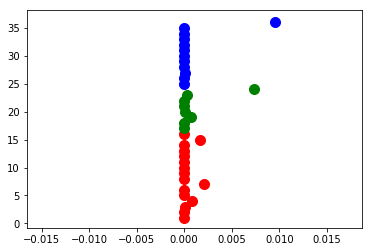

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1]
[ 0.99939561  1.        ]


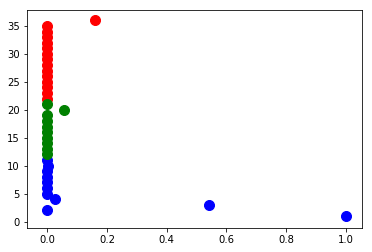

[1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[  4.97343708e-18   1.00000000e+00]


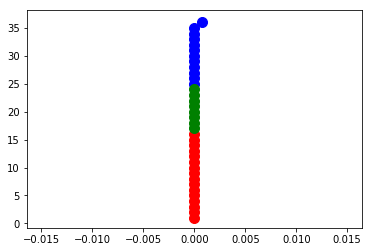

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1]
[  1.63708364e-07   1.00000000e+00]


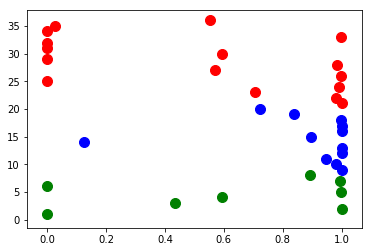

[2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[  8.58475158e-09   1.00000000e+00]


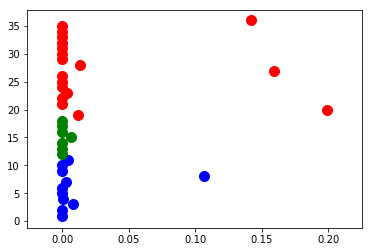

[1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[  3.81035318e-13   1.00000000e+00]


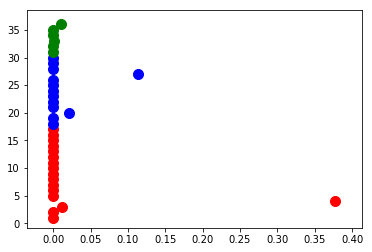

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]
[  3.41450063e-11   1.00000000e+00]


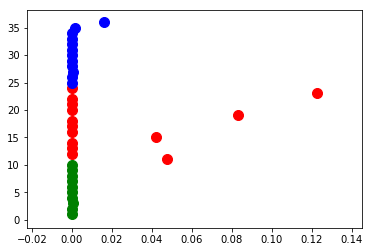

[2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
full
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]


In [71]:
sen2vec = get_avg_Testsen2vec(resume_file, Word2vec, vocab, ivocab)
pred = classifier.predict(np.array(sen2vec))
#from sklearn.preprocessing import StandardScaler
#sc_x = StandardScaler()
#pred = sc_x.fit_transform(pred)
index = np.array([[i] for i in range(1, len(sen2vec)+1)])
pred = np.append(pred, index, axis=1)

print pred[0:5]
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as  sch
denfrograms = sch.dendrogram(sch.linkage(pred, method='ward'))
plt.show()

plt.plot(range(1, 11), wcss)
plt.show()
for j in range(9):
    from sklearn.cluster import AgglomerativeClustering as AC
    cluster = AC(n_clusters=3)
    y_pred = cluster.fit_predict(pred[:, [j, 9]])
    print pred[0, [j, 9]]
    color = ['red', 'blue', 'green', 'pink', 'black']

    for i in range(5):
        plt.scatter(pred[y_pred==i, j], pred[y_pred==i, 9], color=color[i], s=100)
    #plt.scatter(cluster.cluster_centers_[:,0], cluster.cluster_centers_[:,1], s=300, color='yellow')
    plt.show()
    print y_pred
print "full"
cluster = AC(n_clusters=3)
y_pred = cluster.fit_predict(pred)
print y_pred

accuracy = 77.5%